In [1]:
from importlib import reload
import BacktestEngine.backtest as backtest
import BacktestEngine.order_book as order_book
import scipy.odr as odr

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
import pickle
import os
import math
from ReferentialData.polygonData import PolygonAPI
from DataAnalysis import DataExtensions
from Filtering.KalmanFilter import KalmanFilter

In [3]:
## End Date
end_dt = "2025-02-10"
## Start date
start_dt = "2020-01-20"
# Loading "pairs trade" buckets
DIR = r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache'
COR_DIR = r'\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Clustering'
with open(os.path.join(COR_DIR, "correlation_buckets_no_shorts.pkl"), "rb") as file:
    BUCKETS = pickle.load(file)

In [4]:
# Concatenating dictionary value lists
UNIVERSE=[]
for i in list(BUCKETS.values()):
    UNIVERSE.extend(i)

In [5]:
colnames = ["Close", "Volume"]
DataLoader = PolygonAPI()
MID_LOADED = False
HIGH_LOADED = False
if not MID_LOADED:
    mid_df = {}
if not HIGH_LOADED:
    high_df = {}
### loading in low frequency data
if len(mid_df) == 0:
    mid_df = DataLoader.getPrices(UNIVERSE, timespan= "day", from_ = start_dt, 
                                    to_=end_dt,
                                  logDir=os.path.join(DIR,"Beta_Callibration"), _parallel=True)
    MID_LOADED = True

### loading in high frequency data
if len(high_df) == 0:
    high_df = DataLoader.getPrices(UNIVERSE,from_ = start_dt, 
                                    to_=end_dt, timespan="minute", logDir=DIR, _parallel=True)
    HIGH_LOADED = True


## Analysis of first correlation bucket

In [6]:
BUCKETS

{'AOA': ['AOA', 'SPXS', 'SPXU', 'SH', 'SDS'],
 'AIQ': ['AIQ', 'SQQQ', 'QID', 'PSQ'],
 'AGQ': ['AGQ', 'ZSL'],
 'AGG': ['AGG', 'TTT', 'TYO', 'TMV', 'TBT', 'TBX', 'PST'],
 'ACWX': ['ACWX', 'EPV', 'EFZ', 'EFU'],
 'ACWI': ['ACWI', 'SPXU', 'SPXS', 'SH', 'SDS'],
 'AAXJ': ['AAXJ', 'EUM', 'EEV'],
 'ZSL': ['ZSL', 'SLV', 'SIVR', 'GLTR'],
 'ZROZ': ['ZROZ', 'TMV', 'TTT', 'TBT'],
 'XBI': ['XBI', 'LABD'],
 'YCL': ['YCL', 'YCS'],
 'YINN': ['YINN', 'YANG', 'YXI', 'FXP'],
 'YCS': ['YCS', 'FXY'],
 'YXI': ['YXI', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'YANG': ['YANG', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'XT': ['XT', 'HIBS'],
 'XTR': ['XTR', 'SQQQ', 'SPXS', 'SPXU', 'SH', 'SDS', 'QID', 'PSQ'],
 'XSOE': ['XSOE', 'EUM', 'EEV'],
 'XSVM': ['XSVM', 'TWM', 'TZA', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XSMO': ['XSMO', 'TZA', 'TWM', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XPP': ['XPP', 'FXP'],
 'XNTK': ['XNTK', 'SQQQ', 'SOXS', 'QID', 'PSQ'],
 'XMLV': ['XMLV', 'SMDD'],
 'XMMO': ['XMMO', 'SMDD'],
 'XLG': ['XLG', 

In [7]:
# bucket_mask = lambda price_data: price_data[0] in BUCKETS[list(BUCKETS.keys())[1]]
bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']
hf_bucket = dict(filter(bucket_mask, high_df[0].items()))
mf_bucket = dict(filter(bucket_mask, mid_df[0].items()))

### Need to find weighting for positions in portfolio

In [8]:
beta = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\^FTW5000_beta.csv')
beta = beta.loc[:, ~beta.columns.str.contains('^Unnamed')]
beta['Beta'] = [float(x.split(",")[0][1:]) for x in beta['Beta']]
beta = beta[beta.apply(bucket_mask, axis=1)]
beta = beta.set_index("Ticker")
beta = beta.to_dict()['Beta']

import yfinance as yf

bm_ticker = "^FTW5000"
## extract benchmark data 
yf_res = yf.Ticker(bm_ticker)
# get historical market data
# hist = mid_df[0]['ACWI']
hist = yf_res.history(interval="1D", period='2y').reset_index().rename(columns={'Close':bm_ticker,
                'Date':'timestamp'}).set_index('timestamp')
hist = hist.tz_localize(None)
bm_data = hist[[bm_ticker]]
bm_data

### save this since yahoo finance is really unstable...
bm_data.to_csv(r'C:\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\BetaModels\FTW5000.csv')



C:\Users\raymo\AppData\Local\Temp\ipykernel_41156\1586568570.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']


In [9]:
corr = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\pairwise_corr.csv')
corr = corr.loc[:, ~corr.columns.str.contains('^Unnamed')]
bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2
corr = corr[corr.apply(bucket_corr_mask, axis=1)]
corr = corr.sort_values(by="Cross Correlation")
corr

C:\Users\raymo\AppData\Local\Temp\ipykernel_41156\4063414317.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2


,Ticker Pair,Cross Correlation
7134,"AOA,SDS",-0.950992
7083,"AOA,SPXU",-0.948960
7125,"AOA,SH",-0.948941
7089,"AOA,SPXS",-0.948182
129160,"SPXS,SH",0.993566
128571,"SPXU,SH",0.994723
152083,"SH,SDS",0.997474
129169,"SPXS,SDS",0.997839
128540,"SPXU,SPXS",0.998401
128578,"SPXU,SDS",0.998524


In [10]:
hf_df = pd.DataFrame()
for ticker in hf_bucket:
    if len(hf_df) == 0:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = temp.set_index('timestamp')
    else:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = hf_df.join(temp.set_index('timestamp'),
                       how = 'left')
hf_df = hf_df.fillna(method='ffill')
hf_df = hf_df.dropna() ## removes dates where not all components are present
hf_df

C:\Users\raymo\AppData\Local\Temp\ipykernel_41156\2129899211.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hf_df = hf_df.fillna(method='ffill')


,SVXY,SVIX,VIXY
timestamp,,,
2022-03-30 04:00:00,28.010,14.79,315.80
2022-03-31 04:00:00,27.280,14.04,331.40
2022-04-01 04:00:00,27.825,14.61,320.00
2022-04-04 04:00:00,28.535,15.33,302.80
2022-04-05 04:00:00,27.325,14.01,328.40
...,...,...,...
2025-02-13 05:00:00,51.780,26.52,41.33
2025-02-14 05:00:00,51.900,26.64,41.18
2025-02-18 05:00:00,52.030,26.81,41.00


In [11]:
min(hf_df.index)

Timestamp('2022-03-30 04:00:00')

In [12]:
mf_bucket['SVXY']

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,33.750,33.900,32.650,33.225,7778068.0,33.1842,1582174800000,33294,NaN
1,32.715,32.855,31.740,32.190,8503196.0,32.2007,1582261200000,34567,NaN
2,29.730,30.615,29.095,29.135,11459590.0,29.8246,1582520400000,41449,NaN
3,29.790,29.880,27.420,27.815,13483032.0,28.6994,1582606800000,54238,NaN
4,28.320,28.805,27.650,28.195,12609526.0,28.2848,1582693200000,52757,NaN
...,...,...,...,...,...,...,...,...,...
1246,50.400,50.990,50.085,50.780,799700.0,50.6620,1738645200000,6539,NaN
1247,50.710,51.410,50.510,51.340,922519.0,51.0453,1738731600000,7094,NaN
1248,51.620,51.650,51.070,51.570,869287.0,51.4841,1738818000000,6849,NaN
1249,51.730,51.800,50.610,50.620,989746.0,51.0742,1738904400000,8385,NaN


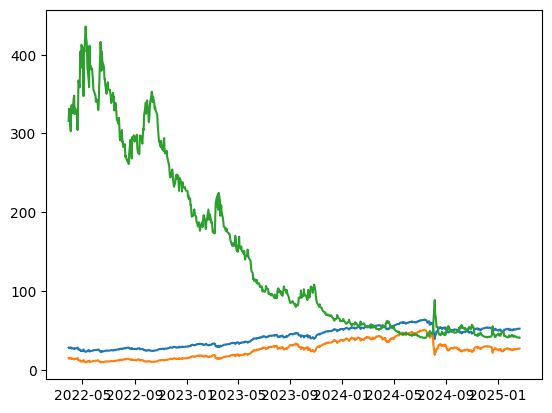

In [13]:
plt.plot(hf_df)

In [14]:
import datetime
from importlib import reload
import OptimizationEngine.mipEngine
reload(OptimizationEngine.mipEngine)

daily_dt = 10e3*60*60*24
min_dt = 10e3*60
dt_ratio = daily_dt / min_dt 

import time
def datetime_to_ms_epoch(dt):
    microseconds = time.mktime(dt.timetuple()) * 1000000 + dt.microsecond
    return int(round(microseconds / float(1000)))

def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

def shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))
    
def getTimeDiffs(dt_list: np.array):
    ## case to ms unix tyime
    if type(dt_list[0]) == np.datetime64:
        dt_list = get_unixtime(dt_list)
    shifted_dt = np.roll(dt_list, 1)
    res = dt_list - shifted_dt
    res[0] = 0 ## as this makes no sense
    return res

logReturnTransform = lambda df : np.log(df.loc[:,~df.columns.str.contains('timestamp')]) - np.log(df.loc[:,~df.columns.str.contains('timestamp')].shift(1))
def logRetDtDailyTransform(df):
    return logReturnTransform(df.loc[:,~df.columns.str.contains('timestamp')]).apply(
        lambda col: np.asarray(col) / getTimeDiffs(np.asarray(df.index.values)) *math.sqrt(dt_ratio))

# print('Beta Adjustment on Mid-Frequency is: {0}.'.format(mf_betaAdj))

mf_summary = {}
for data in mf_bucket:
    mu = logReturnTransform(mf_bucket[data].drop('otc',axis=1))['close'].mean()
    std = logReturnTransform(mf_bucket[data].drop('otc',axis=1))['close'].std()
    mu_hf = logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'].mean()
    std_hf = logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'].std()
    mf_summary[data] = {"Mu": mu, "Sigma":std, "Beta":beta[data],
                        "Mu_Min": mu_hf, "Sigma_Min": std_hf}
mf_summary = pd.DataFrame(mf_summary)

mf_summary

,SVXY,SVIX,VIXY
Mu,0.000348,0.000793,-0.002468
Sigma,0.025530,0.042817,0.047519
Beta,-0.000241,-0.000147,0.000504
Mu_Min,0.017656,0.031329,-0.101291
Sigma_Min,0.960328,1.617145,1.788994


In [15]:
hf_bucket['VIXY']

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,1128.00,1165.60,1075.200,1160.80,1.634902e+05,1119.9360,1582520400000,66037,NaN
1,1120.80,1305.60,1113.600,1272.80,1.919297e+05,1217.8240,1582606800000,72858,NaN
2,1231.20,1290.40,1187.216,1243.20,1.559585e+05,1237.6800,1582693200000,58467,NaN
3,1355.20,1445.60,1321.600,1444.80,2.770670e+05,1379.0240,1582779600000,121408,NaN
4,1608.00,1644.00,1492.000,1507.20,2.751124e+05,1588.4960,1582866000000,126204,NaN
...,...,...,...,...,...,...,...,...,...
1251,41.89,42.45,41.250,41.33,1.866955e+06,41.7621,1739422800000,15435,NaN
1252,41.29,41.65,41.020,41.18,2.076403e+06,41.3140,1739509200000,20806,NaN
1253,40.95,41.37,40.640,41.00,1.560394e+06,40.9611,1739854800000,13829,NaN
1254,41.27,41.37,40.490,40.50,2.835263e+06,40.8421,1739941200000,22064,NaN


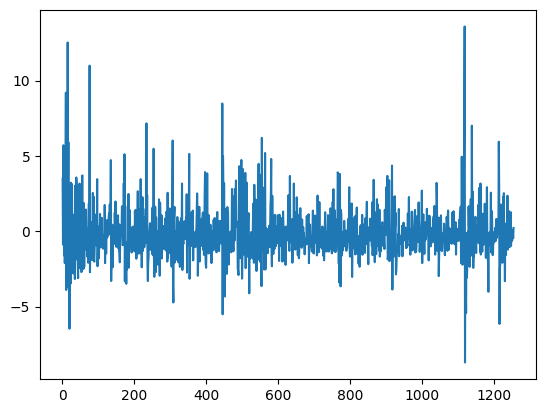

In [16]:
plt.plot(logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'])

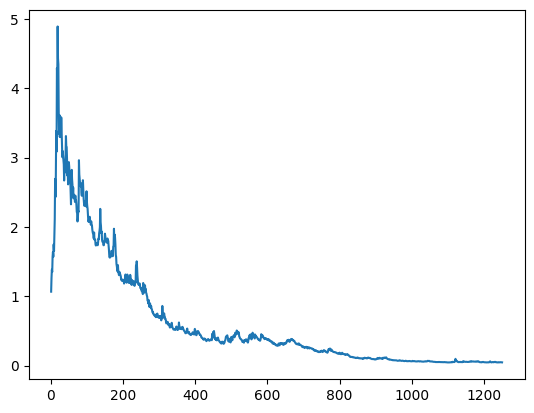

In [17]:
original = np.exp(logReturnTransform(mf_bucket['VIXY'].drop('otc',axis=1))['close'])
plt.plot(original.cumprod())
# plt.plot(mf_bucket['PSQ'].index, mf_bucket['PSQ']['PSQ'])
# mf_bucket['PSQ']

## Running Ordinary Linear Regression for Weighting

In [18]:

hf_df.to_csv(r'C:\Users\raymo\OneDrive\Desktop\test.csv')

In [19]:
import pandas as pd
from numpy import arange
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold#define cross-validation method to evaluate model

def RidgeRegression(X,y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #define model
    model = RidgeCV(alphas=arange(0, 1, 0.01), 
                    cv=cv, 
                    scoring='neg_mean_absolute_error',
                    fit_intercept=False)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model


def ElasticNet(X,y, l1=0.5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    #define model
    model = ElasticNetCV(alphas=arange(0, 1, 0.01), 
                    cv=cv,
                    fit_intercept=False,
                    positive=True,
                    l1_ratio=l1)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model

In [20]:
def tls(X, y):
    """
    Performs Total Least Squares regression.

    Args:
        X (numpy.ndarray): Design matrix (n_samples, n_features)
        y (numpy.ndarray): Target vector (n_samples,)

    Returns:
        numpy.ndarray: Estimated coefficients (n_features,)
    """

    # Construct augmented matrix
    A = np.hstack((X, y.reshape(-1, 1)))

    # Perform SVD
    U, S, V = np.linalg.svd(A)

    # Extract coefficients
    Vxy = V[-1, :-1]
    Vyy = V[-1, -1]

    return -Vxy / Vyy

In [21]:
bm_data

,^FTW5000
timestamp,
2023-02-27,39809.089844
2023-02-28,39704.378906
2023-03-01,39537.910156
2023-03-02,39812.238281
2023-03-03,40450.949219
...,...
2025-02-19,61616.589844
2025-02-20,61288.468750
2025-02-21,60137.691406


In [22]:
# Define a function (quadratic in our case)
# to fit the data with.
# odr initially assumes a linear function
def f(B, x):
    return B[0] + np.dot(B[1:], x)  # B[0] is the intercept, B[1:] are the slopes

### log returns of high frequency data frame

# neutralizeBeta = lambda dcol: dcol[ticker] - mf_summary[ticker] for ticker in df)
hf_log = logReturnTransform(hf_df)
hf_log = pd.merge_asof(hf_log, logReturnTransform(bm_data), on = 'timestamp').dropna().set_index('timestamp')
components = list(hf_log.columns.values)
components.remove(bm_ticker)
### remove beta from FTW5000
hf_log[components] = hf_log[components].apply(lambda dcol: dcol - mf_summary.loc['Beta', dcol.name] 
                                                    *hf_log[bm_ticker] , axis = 0)
hf_log.drop(bm_ticker, axis=1, inplace=True) ## remove benchmark data
reference_ticker = 'VIXY' #hf_df.columns[0]
x_temp = hf_log.loc[:, ~hf_log.columns.str.contains(reference_ticker)]
x_temp = -1*x_temp.iloc[1:]


# x1=  np.array(x_temp['SPXS'])
# x2= np.array(x_temp['SPXU'])
# x3 = np.array(x_temp['SH'])
# x4=np.array(x_temp['SDS'])
# x = np.column_stack((x1,x2,x3,x4))
x = np.array(x_temp)
y = np.array(hf_log[reference_ticker].iloc[1:])

#  model fitting.
odr_model = odr.Model(f)
 
# Create a Data object using sample data created.
data = odr.Data(x, y)
 
# # Set ODR with the model and data.
# ordinal_distance_reg = odr.ODR(data, odr_model,
#                                beta0=[0] + [1]*x.shape[1])
 
# # Run the regression.
# out = ordinal_distance_reg.run()
 
# # print the results
# out.pprint()

# ElasticNet(x,y, 0)
coeffs_ = RidgeRegression(x,y).coef_

# # Plot the data and the fit
# plt.scatter(x, y)
# plt.plot(x, out.beta[0] * x + out.beta[1], color='red')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Orthogonal Linear Regression')
# plt.show()

[ 2.54153452 -0.35302792]


Hurst:  0.41017619828213536


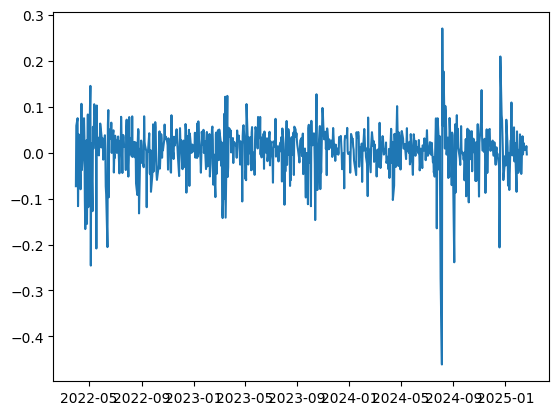

In [23]:
def hurst(ts):
    """Calculates the Hurst Exponent of the time series vector ts"""

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0

reference_ticker = "VIXY"
elementExp = lambda row, coeffs: np.power(np.array(row), coeffs_)
positive_legs = hf_df.loc[:, ~hf_df.columns.str.contains(reference_ticker)]
signal = positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)
signal = signal.add(-1*hf_df[reference_ticker])
raw = pd.DataFrame(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)).join(hf_df[reference_ticker])
print('Hurst: ', hurst(np.array(signal.resample('1D').agg('last').dropna())))
# plt.hist(signal.pct_change(),bins=100)
plt.plot(signal.pct_change())
# plt.scatter(logReturnTransform(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)),
#             logReturnTransform(hf_df[reference_ticker]))

In [24]:
reload(DataExtensions)
outlier_idxs = DataExtensions.zscoreOutliers(signal.pct_change(), params={'std':6})
## these are looking for stock splits 
win1 = outlier_idxs[0]
hf_df[win1[0] - pd.Timedelta(days=2):win1[1]+ pd.Timedelta(days=2)]

,SVXY,SVIX,VIXY
timestamp,,,
2024-08-05 04:00:00,39.22,19.00,88.52
2024-08-06 04:00:00,43.04,21.80,70.36
2024-08-07 04:00:00,44.01,22.00,68.24
2024-08-08 04:00:00,45.73,23.65,62.76


In [25]:
# ### find new beta of signal to benchmark
# from BetaModels.BetaCovFactory import BetaCovFactory
# daily_signal = pd.DataFrame(signal.resample('1D').last().dropna(),
#                             columns=['DailySignal'])
# print(daily_signal)
# bm_ticker = "^FTW5000"

# ## extract benchmark data 
# yf_res = yf.Ticker(bm_ticker)
# info = yf_res.info
# # get historical market data
# hist = yf_res.history(interval="1D", period='5y').rename(columns={'Close':bm_ticker})
# hist = hist.tz_localize(None)
# #hist.index = hist.index.normalize()
# bm_data = hist[[bm_ticker]].rename(columns={'Date':'timestamp'})
# bmFactory = BetaCovFactory(logReturnTransform(bm_data)[1:])
# signalBeta = bmFactory.calculateBeta(logReturnTransform(daily_signal)[1:])[0]
# signalBeta

Signal = pd.DataFrame(signal, columns=['Signal'])
# Signal['timestamp'] = [datetime_to_ms_epoch(ts) for ts in Signal['timestamp']]
Signal

,Signal
timestamp,
2022-03-30 04:00:00,4453.244919
2022-03-31 04:00:00,4128.101836
2022-04-01 04:00:00,4369.405542
2022-04-04 04:00:00,4696.696347
2022-04-05 04:00:00,4149.820337
...,...
2025-02-13 05:00:00,22689.119394
2025-02-14 05:00:00,22823.388608
2025-02-18 05:00:00,22969.404691


In [67]:
positive_legs

,SVXY,SVIX
timestamp,,
2022-03-30 04:00:00,28.010,14.79
2022-03-31 04:00:00,27.280,14.04
2022-04-01 04:00:00,27.825,14.61
2022-04-04 04:00:00,28.535,15.33
2022-04-05 04:00:00,27.325,14.01
...,...,...
2025-02-13 05:00:00,51.780,26.52
2025-02-14 05:00:00,51.900,26.64
2025-02-18 05:00:00,52.030,26.81


In [27]:
reference_ticker

'VIXY'

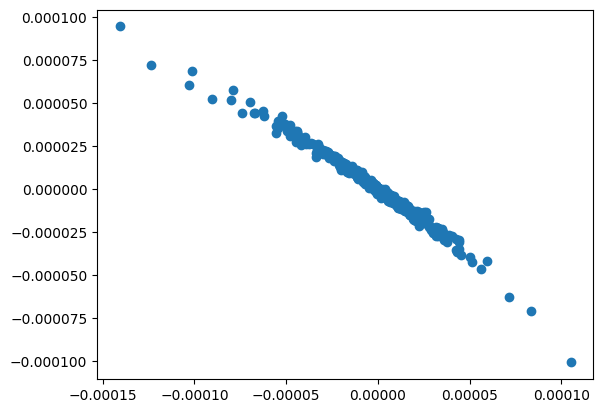

In [28]:
plt.scatter(logRetDtDailyTransform(Signal),
            logRetDtDailyTransform(pd.DataFrame(hf_df[reference_ticker])))

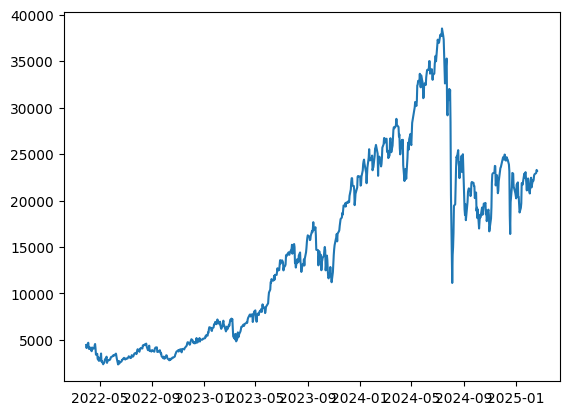

In [29]:
plt.plot(Signal)

Text(0, 0.5, 'Value')

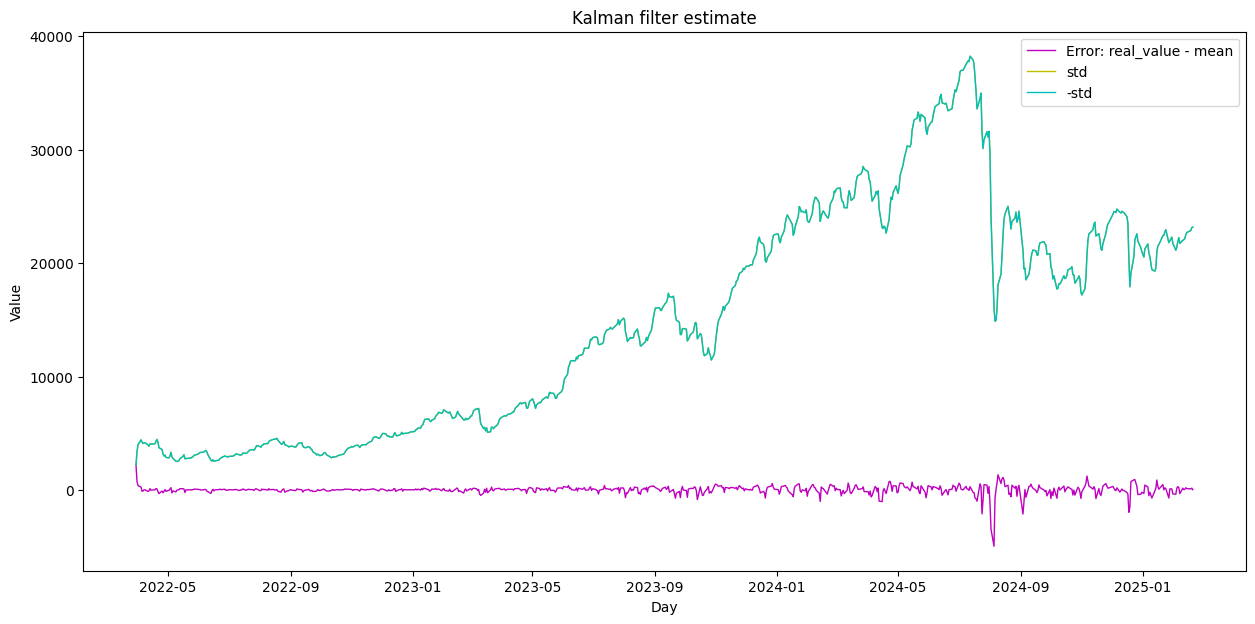

In [31]:
## Filtering
# filter = KalmanFilter(raw)
reload(KalmanFilter)
names = [0, 'VIXY']#['AIQ',0]
means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', Signal, 
                                                     1,
                                                     1)
# Create subplots with shared axes
# fig, axes = plt.subplots(1, 2, sharex=True)
# # Plot data on each subplot
# axes[0].plot(Signal.index, means.squeeze())
# axes[1].plot(Signal.index, covs.squeeze())

mean, std = means.squeeze(), np.std(covs.squeeze())

plt.figure(figsize=(15,7))
plt.plot(Signal.index, Signal['Signal'] - mean, 'm', lw=1)
plt.plot(Signal.index, mean.squeeze() + np.sqrt(covs.squeeze()), 'y', lw=1)
plt.plot(Signal.index, mean.squeeze() - np.sqrt(covs.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

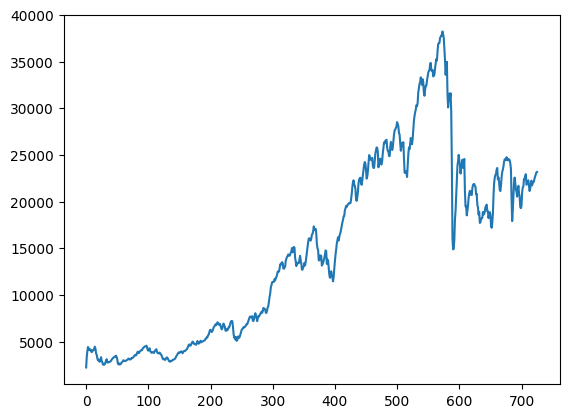

In [32]:
"""
Need to check math on regression on return back to signal level.
logret(Y) = Beta*logret(X) [assume  centered 0]
log(Y) - log(Y') = Beta*(log(X) - log(X'))
log(Y) - log(Y') = log(sum_i x_i^beta_i) - log(sum_i x'_i^beta_i)

"""
state_means, state_covs =means, covs 
plt.plot(state_means)#, state_covs
# DataExtensions.draw_slope_intercept_changes(Signal, state_means)

[ 2227.12245941  3367.71008557  3984.13805858  4424.24758954
  4254.65771463  4108.60234264  4150.90578098  4174.81933527
  3977.5452974   3859.55797689  4063.23016352  4042.77009734
  4082.35490752  4287.50612062  4457.52525645  4232.06029488
  3725.30086697  3588.48160537  3200.44297477  3003.14280307
  3075.63706022  2874.48950135  2838.85611972  2993.59784201
  3330.05895909  2921.180522    2799.24425302  2538.23673394
  2521.16359041  2527.95975418  2581.43572072  2772.10198173
  2961.71913508  3108.44553433  2752.12011418  2776.44871501
  2778.36565471  2818.45840673  2823.18458771  2883.29411328
  2926.9352124   3059.15541366  3163.55949606  3224.06502502
  3309.65901242  3310.67687155  3351.27210994  3445.68187836
  3493.47356992  3352.0755669   3114.29862262  2646.52936975
  2556.65685411  2665.54069234  2543.08305818  2573.20840041
  2634.12285342  2765.14199514  2814.13414169  2885.24223899
  3000.35224365  2962.33132715  2939.7139709   2909.82464617
  2964.1543652   2983.95

Text(0, 0.5, 'Residuals')

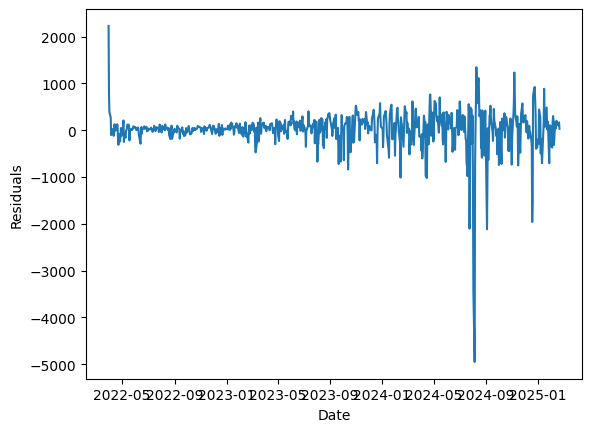

In [33]:
state_means0 = np.array(pd.DataFrame(state_means)[0])
print(state_means0)
resid = Signal['Signal'] - state_means0
stdev = []
for i in range(len(resid)):
    stdev.append(math.sqrt(state_covs[i][0][0]))
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

# adf_test(resid.dropna())

# H, c,  drop = compute_Hc(resid.dropna())
# print('Hurst Exponent', H)

## Portfolio Optimization

In [35]:
means

array([[ 2227.12245941],
       [ 3367.71008557],
       [ 3984.13805858],
       [ 4424.24758954],
       [ 4254.65771463],
       [ 4108.60234264],
       [ 4150.90578098],
       [ 4174.81933527],
       [ 3977.5452974 ],
       [ 3859.55797689],
       [ 4063.23016352],
       [ 4042.77009734],
       [ 4082.35490752],
       [ 4287.50612062],
       [ 4457.52525645],
       [ 4232.06029488],
       [ 3725.30086697],
       [ 3588.48160537],
       [ 3200.44297477],
       [ 3003.14280307],
       [ 3075.63706022],
       [ 2874.48950135],
       [ 2838.85611972],
       [ 2993.59784201],
       [ 3330.05895909],
       [ 2921.180522  ],
       [ 2799.24425302],
       [ 2538.23673394],
       [ 2521.16359041],
       [ 2527.95975418],
       [ 2581.43572072],
       [ 2772.10198173],
       [ 2961.71913508],
       [ 3108.44553433],
       [ 2752.12011418],
       [ 2776.44871501],
       [ 2778.36565471],
       [ 2818.45840673],
       [ 2823.18458771],
       [ 2883.29411328],


In [36]:
bounds = {'Mu':0, 'Sigma':0, 'Beta':0, 'Mu_Min':0, 'Sigma_Min':0}
MIP = OptimizationEngine.mipEngine.mipEngine()
# MIP._addVariables(mf_summary.columns, var_bounds=(None,None), var_type="INTEGER")
MIP._addConstraints(mf_summary, bounds, var_bounds=(1,None))
MIP._optimize()
#pd.DataFrame(mf_summary)

optimal solution cost 0.0 found
solution:


In [37]:
raw = raw.reset_index().set_index('timestamp')
raw

,0,VIXY
timestamp,,
2022-03-30 04:00:00,4769.044919,315.80
2022-03-31 04:00:00,4459.501836,331.40
2022-04-01 04:00:00,4689.405542,320.00
2022-04-04 04:00:00,4999.496347,302.80
2022-04-05 04:00:00,4478.220337,328.40
...,...,...
2025-02-13 05:00:00,22730.449394,41.33
2025-02-14 05:00:00,22864.568608,41.18
2025-02-18 05:00:00,23010.404691,41.00


In [38]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
## analysis between adr spread and volume pct
df = signal

df.fillna(method='ffill', inplace=True)
# df['ADR_Vol_Pct'] = df['TSMC34_SA_Volume']/(df['TSMC34_SA_Volume'] +df['TSM_Volume'])
mean = df.mean()
std = df.std()
# df['ADR_Vol_Pct'] = (df['ADR_Vol_Pct'] - mean)/std
# df['ADR_Spread'] = df['TSM_Close'] - df['TSMC34_SA_Close']
# mean = df['ADR_Spread'].mean()
# std = df['ADR_Spread'].std()
# df['ADR_Spread'] = (df['ADR_Spread'] - mean)/std
coint_test_result = coint_johansen(raw, det_order=1, k_ar_diff=0)
tracevalues = coint_test_result.lr1
critical_values = coint_test_result.cvt
for i, (stock1, stock2) in enumerate([list(raw.columns.values)]):
    if (tracevalues[i] > critical_values[:, 1]).all():
        print(f"Pair {i + 1} ({stock1} and {stock2}) is cointegrated.")
    else:
        print(f"Pair {i + 1} ({stock1} and {stock2}) is not cointegrated.")

Pair 1 (0 and VIXY) is not cointegrated.


C:\Users\raymo\AppData\Local\Temp\ipykernel_41156\246132147.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [39]:
np.std(np.array(covs).flatten())/np.array(means).flatten()
# init_mu

array([1.98842007e-06, 1.31497513e-06, 1.11152147e-06, 1.00095099e-06,
       1.04084871e-06, 1.07784951e-06, 1.06686474e-06, 1.06075369e-06,
       1.11336381e-06, 1.14739953e-06, 1.08988534e-06, 1.09540115e-06,
       1.08477952e-06, 1.03287433e-06, 9.93478388e-07, 1.04640641e-06,
       1.18875097e-06, 1.23407488e-06, 1.38370064e-06, 1.47460687e-06,
       1.43984967e-06, 1.54060573e-06, 1.55994345e-06, 1.47930859e-06,
       1.32984282e-06, 1.51598129e-06, 1.58201808e-06, 1.74469739e-06,
       1.75651236e-06, 1.75179015e-06, 1.71550078e-06, 1.59750797e-06,
       1.49523125e-06, 1.42465260e-06, 1.60910673e-06, 1.59500695e-06,
       1.59390647e-06, 1.57123305e-06, 1.56860271e-06, 1.53590124e-06,
       1.51300069e-06, 1.44760707e-06, 1.39983301e-06, 1.37356256e-06,
       1.33803966e-06, 1.33762828e-06, 1.32142508e-06, 1.28521876e-06,
       1.26763661e-06, 1.32110835e-06, 1.42197507e-06, 1.67330658e-06,
       1.73212725e-06, 1.66137213e-06, 1.74137254e-06, 1.72098576e-06,
      

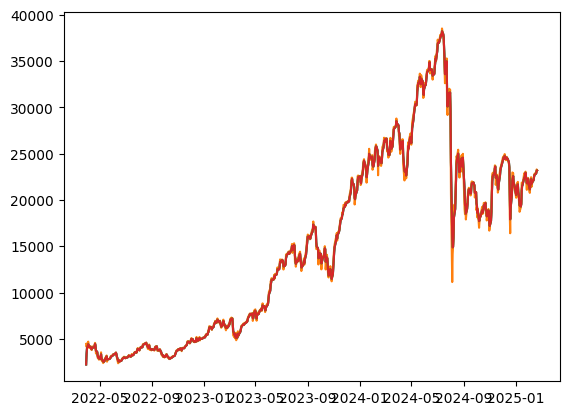

In [45]:
### roll filter over 90 day windows
roll = 0
training_period = datetime.timedelta(days=90)
# testing_period = datetime.timedelta(days=30)
min_time_delta = datetime.timedelta(hours=1)
start_date = Signal.index[0] 
means = []
covs = []
init_mu = 1#np.mean(Signal[start_date:start_date+training_period])
init_cov = 1#np.var(Signal[start_date:start_date+training_period])
start_date += (training_period + min_time_delta)
# while (start_date + training_period < Signal.index[-1]):
#     means_temp, covs_temp = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
#                 Signal[start_date:start_date+training_period], 
#                 init_mu,
#                 init_cov
#                 )
#     means.extend(means_temp)
#     covs.extend(covs_temp)
#     init_mu = 1#np.mean(Signal[start_date:start_date+training_period])
#     init_cov = 1#np.var(Signal[start_date:start_date+training_period])
#     # print(len(Signal[start_date:start_date+training_period]),len(covs))
#     # print()
#     start_date += (training_period + min_time_delta)
# means_temp, covs_temp = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
#             Signal[start_date:], 
#             init_mu,
#             init_cov)
# means.extend(means_temp)
# covs.extend(covs_temp)

means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
            Signal, 
            init_mu,
            init_cov
            )
# print(len(Signal[start_date:]), len(covs))
plt.plot(Signal.index, np.array(means).flatten())
plt.plot(Signal)
plt.plot(Signal.index, np.array(means).flatten() + np.std(np.array(covs).flatten()))
plt.plot(Signal.index, np.array(means).flatten() - np.std(np.array(covs).flatten()))

In [48]:
means

array([[ 2227.12245941],
       [ 3367.71008557],
       [ 3984.13805858],
       [ 4424.24758954],
       [ 4254.65771463],
       [ 4108.60234264],
       [ 4150.90578098],
       [ 4174.81933527],
       [ 3977.5452974 ],
       [ 3859.55797689],
       [ 4063.23016352],
       [ 4042.77009734],
       [ 4082.35490752],
       [ 4287.50612062],
       [ 4457.52525645],
       [ 4232.06029488],
       [ 3725.30086697],
       [ 3588.48160537],
       [ 3200.44297477],
       [ 3003.14280307],
       [ 3075.63706022],
       [ 2874.48950135],
       [ 2838.85611972],
       [ 2993.59784201],
       [ 3330.05895909],
       [ 2921.180522  ],
       [ 2799.24425302],
       [ 2538.23673394],
       [ 2521.16359041],
       [ 2527.95975418],
       [ 2581.43572072],
       [ 2772.10198173],
       [ 2961.71913508],
       [ 3108.44553433],
       [ 2752.12011418],
       [ 2776.44871501],
       [ 2778.36565471],
       [ 2818.45840673],
       [ 2823.18458771],
       [ 2883.29411328],


[[ 2227.12245941]
 [ 3367.71008557]
 [ 3984.13805858]
 [ 4424.24758954]
 [ 4254.65771463]
 [ 4108.60234264]
 [ 4150.90578098]
 [ 4174.81933527]
 [ 3977.5452974 ]
 [ 3859.55797689]
 [ 4063.23016352]
 [ 4042.77009734]
 [ 4082.35490752]
 [ 4287.50612062]
 [ 4457.52525645]
 [ 4232.06029488]
 [ 3725.30086697]
 [ 3588.48160537]
 [ 3200.44297477]
 [ 3003.14280307]
 [ 3075.63706022]
 [ 2874.48950135]
 [ 2838.85611972]
 [ 2993.59784201]
 [ 3330.05895909]
 [ 2921.180522  ]
 [ 2799.24425302]
 [ 2538.23673394]
 [ 2521.16359041]
 [ 2527.95975418]
 [ 2581.43572072]
 [ 2772.10198173]
 [ 2961.71913508]
 [ 3108.44553433]
 [ 2752.12011418]
 [ 2776.44871501]
 [ 2778.36565471]
 [ 2818.45840673]
 [ 2823.18458771]
 [ 2883.29411328]
 [ 2926.9352124 ]
 [ 3059.15541366]
 [ 3163.55949606]
 [ 3224.06502502]
 [ 3309.65901242]
 [ 3310.67687155]
 [ 3351.27210994]
 [ 3445.68187836]
 [ 3493.47356992]
 [ 3352.0755669 ]
 [ 3114.29862262]
 [ 2646.52936975]
 [ 2556.65685411]
 [ 2665.54069234]
 [ 2543.08305818]
 [ 2573.20

Text(0, 0.5, 'Residuals')

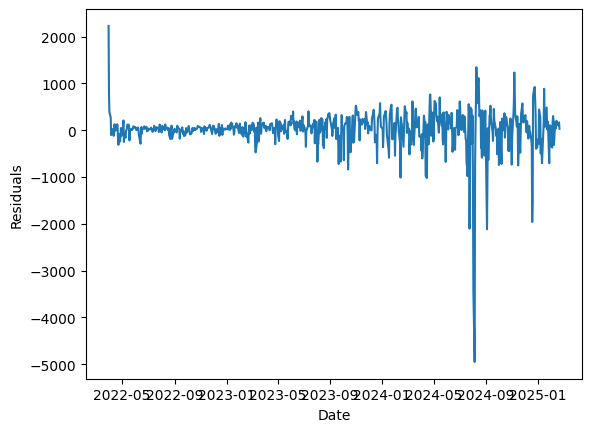

In [50]:
state_means0 = np.array(pd.DataFrame(means.flatten()))
print(means)
resid = Signal['Signal'] - means.flatten()
stdev = []
# for i in range(len(resid)):
#     stdev.append(math.sqrt(covs[0].flatten()[i]))
stdev = covs.flatten()
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

# adf_test(resid.dropna())

# H, c,  drop = compute_Hc(resid.dropna())
# print('Hurst Exponent', H)

Text(0, 0.5, 'Value')

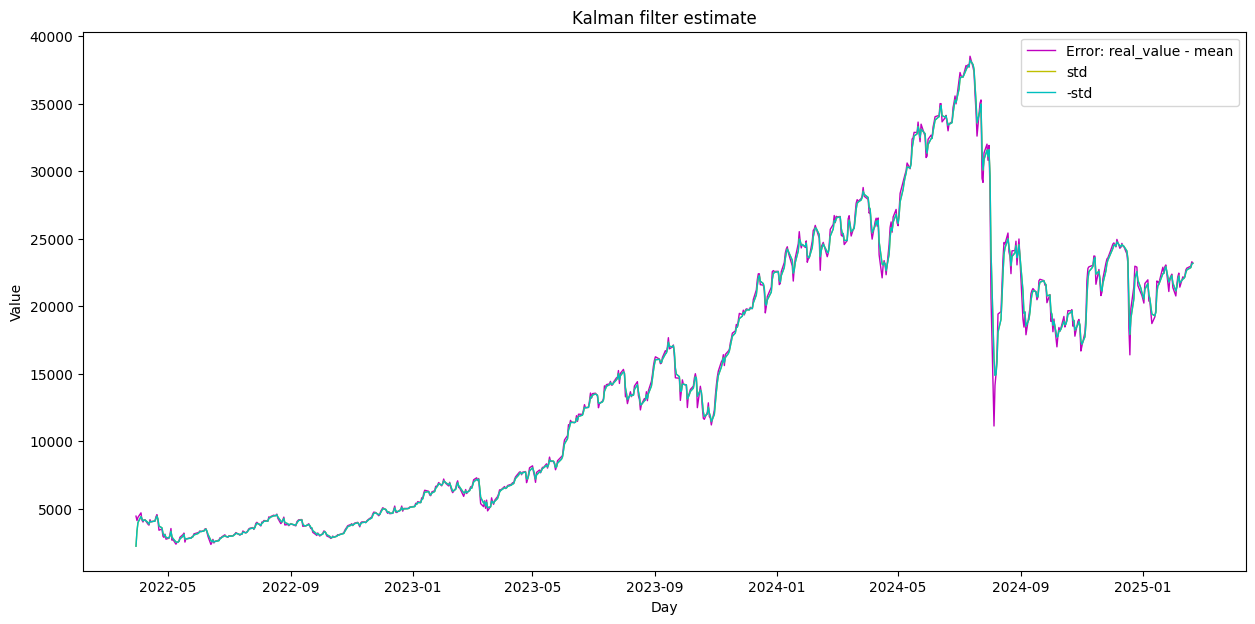

In [60]:
# mean, std = means.squeeze(), np.std(covs.squeeze())

plt.figure(figsize=(15,7))
plt.plot(Signal.index, Signal['Signal'], 'm', lw=1)
plt.plot(Signal.index, np.array(means).squeeze() + 2*np.sqrt(covs.flatten()), 'y', lw=1)
plt.plot(Signal.index, np.array(means).squeeze() - 2*np.sqrt(covs.flatten()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

In [ ]:
from statsmodels.regression.rolling import RollingOLS

df = pd.DataFrame()
df['primitive_signal'] = Signal['Signal']
df = df.merge(hf_df, on='timestamp', how='left')
df['filter_resid'] = resid
df['filter_spread'] = stdev

def simpleFilterSignal(dr, epsilon):
    if dr.filter_resid < -dr.filter_spread*epsilon:
        return -1
    elif dr.filter_resid > dr.filter_spread*epsilon:
        return 1
    else:
        return 0

# means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', Signal, 
#                                                      np.mean(Signal[-252:]),
#                                                      np.var(Signal[-252:]))

df['Signal'] = df.apply(lambda dr: simpleFilterSignal(dr, 2), axis=1)
df['BuySell'] = (df['Signal'] - df['Signal'].shift(1))/2
df = df.reset_index().rename(columns={"timestamp":"Date"})
### rolling coefficient
window = 21 #21 days
LEGS = list(mf_bucket.keys())
ret_df = logRetDtDailyTransform(df[LEGS])
# df['HedgeRatio'] = ret_
model = RollingOLS(-1*ret_df[reference_ticker], ret_df[[x for x in LEGS if x != reference_ticker]], window=window)
hedge_ratios = model.fit().params.shift(1)
for ticker in LEGS:
    if ticker == reference_ticker:
        df[f'{ticker}_hr'] = -1
    else:
        df[f'{ticker}_hr'] = hedge_ratios[ticker]
df

,Date,primitive_signal,SVXY,SVIX,VIXY,filter_resid,filter_spread,Signal,BuySell,SVXY_hr,SVIX_hr,VIXY_hr
0,2022-03-30 04:00:00,4453.244919,28.010,14.79,315.80,2226.122459,0.500000,1,NaN,NaN,NaN,-1
1,2022-03-31 04:00:00,4128.101836,27.280,14.04,331.40,760.391751,0.600000,1,0.0,NaN,NaN,-1
2,2022-04-01 04:00:00,4369.405542,27.825,14.61,320.00,385.267483,0.615385,1,0.0,NaN,NaN,-1
3,2022-04-04 04:00:00,4696.696347,28.535,15.33,302.80,272.448757,0.617647,1,0.0,NaN,NaN,-1
4,2022-04-05 04:00:00,4149.820337,27.325,14.01,328.40,-104.837377,0.617978,-1,-1.0,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
721,2025-02-13 05:00:00,22689.119394,51.780,26.52,41.33,199.427287,0.618034,1,0.0,1.278997,0.375792,-1
722,2025-02-14 05:00:00,22823.388608,51.900,26.64,41.18,127.460721,0.618034,1,0.0,1.521798,0.193161,-1
723,2025-02-18 05:00:00,22969.404691,52.030,26.81,41.00,104.458844,0.618034,1,0.0,1.530259,0.187948,-1
724,2025-02-19 05:00:00,23297.261299,52.320,27.00,40.50,165.129809,0.618034,1,0.0,1.583150,0.159106,-1


In [ ]:
BBO = order_book.Book()
HOLDING_PERIOD_CHECK = {}
isLong = False
hasPosition = False

def isFirstTrade(ticker, date):
    if ticker not in HOLDING_PERIOD_CHECK:
        return True
    if date not in HOLDING_PERIOD_CHECK[ticker]:
        return True
    return False

pairsLEGS = [x for x in LEGS if x != reference_ticker]

for row in df.iloc[window:].itertuples():
    if (row.BuySell == 1 
        and not hasPosition
        and isFirstTrade(reference_ticker, row.Date.normalize())):
        print('bought spread at ', row.Date)
        BBO.addOrder(row.Date, reference_ticker, row[reference_ticker],-10 * row[f'{reference_ticker}_hr'])
        for LEG in pairsLEGS:
            BBO.addOrder(row.Date, LEG, row[LEG], 10 * row[f'{LEG}_hr'])
        if reference_ticker not in HOLDING_PERIOD_CHECK:
            HOLDING_PERIOD_CHECK[reference_ticker] = []
        HOLDING_PERIOD_CHECK[reference_ticker].append(row.Date.normalize())
        isLong = True
        hasPosition = True
    elif (row.BuySell == -1 
        and not hasPosition
        and isFirstTrade(reference_ticker, row.Date.normalize())):
        print('sold spread at ', row.Date)
        BBO.addOrder(row.Date, reference_ticker, row[reference_ticker], 10 * row[f'{reference_ticker}_hr'])
        for LEG in pairsLEGS:
            BBO.addOrder(row.Date, LEG, row[LEG], -10 * row[f'{LEG}_hr'])
        isLong = False
        if reference_ticker not in HOLDING_PERIOD_CHECK:
            HOLDING_PERIOD_CHECK[reference_ticker] = []
        HOLDING_PERIOD_CHECK[reference_ticker].append(row.Date.normalize())
        hasPosition = True
        isLong = False
    else:
        if hasPosition and isFirstTrade(reference_ticker, row.Date.normalize()):
            print('exit spread at ', row.Date)
            prices = {}
            for ticker in LEGS:
                prices[ticker] = row[ticker]
            BBO.unwindALL(row.Date, prices =prices)
            if "SVIX" not in HOLDING_PERIOD_CHECK:
                HOLDING_PERIOD_CHECK[reference_ticker] = []
                HOLDING_PERIOD_CHECK[reference_ticker].append(row.Date.normalize())
            hasPosition = False
            isLong = False

#BBO.addOrder(df_res.iloc[100]["Date"], "TSM", 300.0, 10)
#BBO.addOrder(df_res.iloc[120]["Date"], "TSM", 250.0, 25)
#BBO.addOrder(df_res.iloc[200]["Date"], "TSM", 350.0, -30)
#BBO.getTickerBook(["TSLA"]).tail(1)#.loc['Quantity']
#BBO.get_history()

#BBO.addOrder(df_res.iloc[50]["Date"], "TSMC34.SA", 300.0, 10)
#BBO.addOrder(df_res.iloc[150]["Date"], "TSMC34.SA", 250.0, -25)

sold spread at  2022-04-05 04:00:00
exit spread at  2022-04-06 04:00:00
bought spread at  2022-04-07 04:00:00
exit spread at  2022-04-08 04:00:00
sold spread at  2022-04-11 04:00:00
exit spread at  2022-04-12 04:00:00
bought spread at  2022-04-13 04:00:00
exit spread at  2022-04-14 04:00:00
bought spread at  2022-04-18 04:00:00
exit spread at  2022-04-19 04:00:00
sold spread at  2022-04-21 04:00:00
exit spread at  2022-04-22 04:00:00
bought spread at  2022-04-28 04:00:00
exit spread at  2022-04-29 04:00:00
bought spread at  2022-05-03 04:00:00
exit spread at  2022-05-04 04:00:00
sold spread at  2022-05-05 04:00:00
exit spread at  2022-05-06 04:00:00
bought spread at  2022-05-11 04:00:00
exit spread at  2022-05-12 04:00:00
sold spread at  2022-05-18 04:00:00
exit spread at  2022-05-19 04:00:00
sold spread at  2022-06-09 04:00:00
exit spread at  2022-06-10 04:00:00
bought spread at  2022-06-15 04:00:00
exit spread at  2022-06-16 04:00:00
bought spread at  2022-06-17 04:00:00
exit spread 

In [63]:
BBO.getOrderDf()

,Date,Ticker,Price,Quantity,Longshort
0,2022-04-05 04:00:00,SVIX,14.01,10,True
1,2022-04-05 04:00:00,VIXY,328.40,-10,False
2,2022-04-06 04:00:00,SVIX,13.71,10,True
3,2022-04-06 04:00:00,VIXY,336.00,-10,False
4,2022-04-07 04:00:00,SVIX,14.12,-10,False
...,...,...,...,...,...
727,2025-02-05 05:00:00,VIXY,42.03,10,True
728,2025-02-07 05:00:00,SVIX,25.49,10,True
729,2025-02-07 05:00:00,VIXY,43.21,-10,False
730,2025-02-10 05:00:00,SVIX,26.13,10,True


In [64]:

df1 = df[['Date', 'SVIX']]
df2 = df[['Date', 'VIXY']]
df1['Ticker'] = 'SVIX'
df2['Ticker'] = 'VIXY'

df_res = pd.concat([df1.rename(columns={'SVIX':'Price'}),df2.rename(columns={'VIXY':'Price'})])
print(df_res)
#df1.drop('index', inplace=True)
#df_res.rename(columns={'Datetime':'Date'}, inplace=True)
BBO.backfillPnL(df_res)

                   Date  Price Ticker
0   2022-03-30 04:00:00  14.79   SVIX
1   2022-03-31 04:00:00  14.04   SVIX
2   2022-04-01 04:00:00  14.61   SVIX
3   2022-04-04 04:00:00  15.33   SVIX
4   2022-04-05 04:00:00  14.01   SVIX
..                  ...    ...    ...
721 2025-02-13 05:00:00  41.33   VIXY
722 2025-02-14 05:00:00  41.18   VIXY
723 2025-02-18 05:00:00  41.00   VIXY
724 2025-02-19 05:00:00  40.50   VIXY
725 2025-02-20 05:00:00  40.73   VIXY

[1452 rows x 3 columns]


C:\Users\raymo\AppData\Local\Temp\ipykernel_41156\2903296011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Ticker'] = 'SVIX'
C:\Users\raymo\AppData\Local\Temp\ipykernel_41156\2903296011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Ticker'] = 'VIXY'


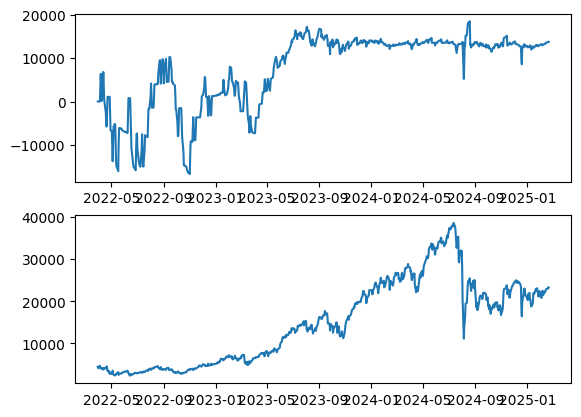

In [65]:
hist = BBO.getHistoryDf()
figure, axis = plt.subplots(2,1)

# For Sine Function
axis[0].plot(hist.index, hist['PnL'])
# axis[0, 0].set_title("Sine Function")

# For Cosine Function
axis[1].plot(Signal.index, Signal)
# axis[0, 1].set_title("Cosine Function")
# plt.plot(hist['PnL'])
plt.show()

In [ ]:
### Sharpe Ratio and whatnot


### drawdown


In [59]:
BBO.getHistoryDf()

,CostBasis,Value,PnL,Cash
Date,,,,
2022-03-30 04:00:00,0.0,0.0,0.0,0.0
2022-03-31 04:00:00,0.0,0.0,0.0,0.0
2022-04-01 04:00:00,0.0,0.0,0.0,0.0
2022-04-04 04:00:00,0.0,0.0,0.0,0.0
2022-04-05 04:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2025-02-13 05:00:00,-13108.4,-592.4,26575.5,14059.5
2025-02-14 05:00:00,-13108.4,-581.6,26586.3,14059.5
2025-02-18 05:00:00,-13108.4,-567.6,26600.3,14059.5
